# Detection of TOXicity in comments in Spanish (DETOXIS 2021)

## SESIÓN 2.3: Clasificador basado en BERT y evaluación

### Realizado por Álvaro Mazcuñán y Miquel Marín

In [2]:
pip install transformers

**IMPORTANTE**: VER LA JUSTIFICACIÓN QUE SE HA COMENTADO AL FINAL DEL NOTEBOOK CUANDO SE ENTRENA EL MODELO BETO PARA LA VARIABLE DE `TOXICITY_LEVEL`

### Librerías

In [23]:
import transformers
from transformers import BertModel, AutoTokenizer, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from collections import defaultdict
from textwrap import wrap
from collections import Counter
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings

In [24]:
warnings.filterwarnings("ignore")

In [11]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Carga de los datos

In [4]:
df = pd.read_csv("DATASET_DETOXIS.csv")
df

,topic,thread_id,comment_id,reply_to,comment_level,comment,argumentation,constructiveness,positive_stance,negative_stance,target_person,target_group,stereotype,sarcasm,mockery,insult,improper_language,aggressiveness,intolerance,toxicity,toxicity_level
0,CR,0_000,0_002,0_002,1,Pensó: Zumo para restar.,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,CR,0_001,0_003,0_003,1,Como les gusta el afeitado en seco a esta gente.,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1
2,CR,0_002,0_004,0_004,1,"asi me gusta, que se maten entre ellos y en al...",0,0,0,0,0,1,0,0,0,0,0,1,1,1,2
3,CR,0_003,0_005,0_005,1,"Loss mas valientes, los que mejor cortan nuest...",0,0,0,0,1,1,0,1,1,0,0,0,0,1,1
4,CR,0_004,0_006,0_006,1,Costumbres...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3458,MI,20_134,20_164,20_164,1,Ya decía yo que veía menos moros,0,0,0,0,0,1,0,0,1,1,0,0,0,1,1
3459,MI,20_006,20_165,20_008,2,+1. Como lo sabes...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3460,MI,20_135,20_166,20_166,1,"Seguirán cobrando paguitas en Marruecos,expoli...",0,0,0,0,0,1,1,0,0,0,0,0,1,1,1
3461,MI,20_136,20_167,20_167,1,"pobres, se arriesgan en pateras porque huyen d...",0,0,0,0,0,1,0,0,1,0,0,0,0,1,1


In [13]:
subset = df[["comment", "toxicity","toxicity_level"]]
subset_df = df[["comment", "toxicity"]]
subset_df2 = df[["comment", "toxicity_level"]]

### Leer tweets y preprocesado

In [9]:
def tweet_preprocessing_not_tokenized(tweet):
    tweet = tweet.lower() # Se empieza pasando todos los mensajes a minúsculas
    tweet = re.sub(r"http\S+|www\S+|https\S+", "" ,tweet , flags=re.MULTILINE) # Quitar URLs
    tweet = re.sub(r"\@\w+|\#", "", tweet) # Quitar @ y #
    tweet = re.sub(r"[\U00010000-\U0010ffff]|:\)|:\(|XD|xD|;\)|:,\(|:D|D:", "", tweet) # Quitar emojis y emoticones
    tweet = tweet.translate(str.maketrans('', '', string.punctuation)) # Quitar signos de puntuación
    tokenized_tweets = word_tokenize(tweet)
    filtered_tweets = [word for word in tokenized_tweets if not word in set(stopwords.words('spanish'))] # Quitar stopwords y filtrar
    
    stemming = PorterStemmer() # Inicializamos PorterStemmer para obtener la raíz de cada una de las palabras
    stemmed_tweets = [stemming.stem(word) for word in filtered_tweets]
    lemmatization = WordNetLemmatizer() # Inicializamos el Lemmatizer para obtener los lemas de las palabras
    lemma_tweets = [lemmatization.lemmatize(word, pos='a') for word in stemmed_tweets] 
    return " ".join(lemma_tweets) # NO TOKENIZADO

preprocessing = lambda x: tweet_preprocessing_not_tokenized(x)

In [12]:
subset['comment'] = pd.DataFrame(subset["comment"].apply(preprocessing))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Modelo con GridSearch

Se ha decidido evaluar un modelo de SVM, realizando previamente el TF-IDF, tal y como se hizo en la anterior práctica, utilizando la técnica de GridSearch y, de esta forma, intentar obtener los parámetros óptimos para dicho algoritmo.

In [34]:
X = subset["comment"]
y = subset["toxicity"]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [45]:
tuned_parameters =  [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3],
                     'C': [0.001, 0.10, 0.1, 10]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3],
                     'C': [0.001, 0.10, 0.1, 10] },{'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10]}]

In [46]:
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  tfidf_vect = TfidfVectorizer()
  tfidf_vect.fit(X)
  train_X_Tfidf = tfidf_vect.transform(X_train)
  test_X_Tfidf = tfidf_vect.transform(X_test)

  clf = GridSearchCV(SVC(), tuned_parameters)
  clf.fit(train_X_Tfidf, y_train)

  svm_pred=clf.predict(test_X_Tfidf)
  print("\t\tf1-score: {}".format(f1_score(y_test, svm_pred)))

		f1-score: 0.0
		f1-score: 0.3887323943661972
		f1-score: 0.417910447761194
		f1-score: 0.0
		f1-score: 0.39572192513368987


Tal y como se puede observar, el f1-score que se obtiene en este caso, utilizando GridSearch, es muy inferior al que se obtuvo en la anterior entrega sin utilizar dicha técnica para obtener los parámetros óptimos.


A continuación, una vez realizada la tarea con GridSearch, se va a pasar a realizar un modelo BERT, concretamente una variante, BETO, el cual evalúa los comentarios/tweets en castellano.

#### Parámetros iniciales

In [ ]:
RANDOM_SEED = 42
MAX_LEN = 200
BATCH_SIZE = 16
NCLASSES = 2
NCLASSES_LEVELS = 4

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Carga del modelo - BETO

En este caso, se va a cargar el modelo `bert-base-spanish-wwm-uncased` el cual se refiere a la variante de BERT, BETO

In [ ]:
PRE_TRAINED_MODEL_NAME = 'dccuchile/bert-base-spanish-wwm-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

A continuación se observan cada uno de los tweets para ver cuál es la longitud máxima y, de esa forma, asignarlo a la hora de entrenar el modelo. Se puede ver como dicho valor se acerca alrededor de 200 (valor asignado previamente) 

In [ ]:
token_lens = []

for txt in subset_df.comment:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


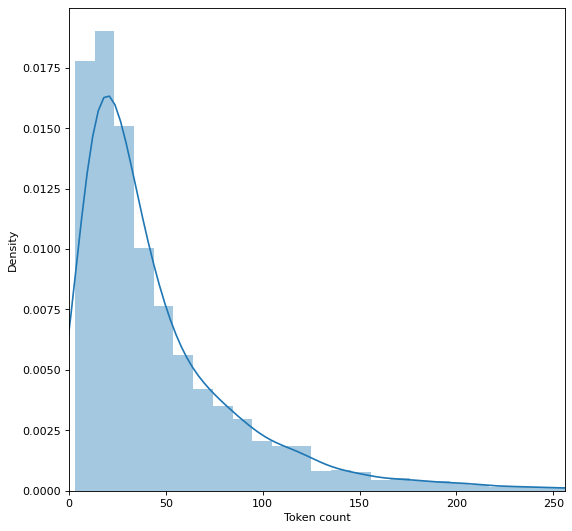

In [ ]:
figure(figsize=(8, 8), dpi=80)
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

### Creación de Clases necesarias para inicializar el modelo que se evaluará posteriormente

In [ ]:
class TOXICITY_DATASET(Dataset):

  def __init__(self, reviews, labels, tokenizer, max_len):
    self.reviews = reviews
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      review,
      max_length=self.max_len,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'label': torch.tensor(label, dtype=torch.long)
    }

In [ ]:
def data_loader(df, tokenizer, max_len, batch_size):
  dataset = TOXICITY_DATASET(
    reviews=df.comment.to_numpy(),
    labels=df.toxicity.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
  )

  return DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    num_workers=4
  )

def data_loader_levels(df, tokenizer, max_len, batch_size):
  dataset = TOXICITY_DATASET(
    reviews=df.comment.to_numpy(),
    labels=df.toxicity_level.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
  )

  return DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    num_workers=4
  )

### División de los tweets en un conjunto de entrenamiento y de test

#### División para la variable `Toxicity`

In [ ]:
df_train, df_test = train_test_split(subset_df, test_size=0.1, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### División para la variable `Toxicity_level`

In [ ]:
df_train_levels, df_test_levels = train_test_split(subset_df2, test_size=0.1, random_state=RANDOM_SEED, stratify=subset_df2["toxicity_level"])

train_data_loader_levels = data_loader_levels(df_train_levels, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader_levels = data_loader_levels(df_test_levels, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Clases con las funciones necesarias para entrenar y evaluar el modelo

In [ ]:
class BERTToxicityClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BERTToxicityClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, cls_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            return_dict = False
        )
        drop_output = self.drop(cls_output)
        output = self.linear(drop_output)
        return output

        """
        last_hidden_states = self.bert(input_ids=input_ids,
                                       attention_mask=attention_mask, return_dict=False)
        pooled_output = last_hidden_states[0][:,0,:]
        output = self.drop(pooled_output)
        return self.out(output)
        """

In [ ]:
model = BERTToxicityClassifier(NCLASSES)
model = model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  
  for batch in data_loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["label"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions, correct_predictions.double() / n_examples, np.mean(losses), preds

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["label"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)


      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)

      losses.append(loss.item())

  return correct_predictions, correct_predictions.double() / n_examples, np.mean(losses), preds

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

### Evaluación para `Toxicity`

Tal y como se puede observar en el output de abajo, el accuracy que se obtiene en este caso es de alrededor de 0.78, valor más que aceptable.

In [ ]:
for epoch in range(EPOCHS):
  print('Epoch {} de {}'.format(epoch+1, EPOCHS))
  print('------------------')
  train_pred, train_acc, train_loss = train_model(
      model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
  )
  test_pred, test_acc, test_loss = eval_model(
      model, test_data_loader, loss_fn, device, len(df_test)
  )
  print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
  print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
  print('')

Epoch 1 de 5
------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Entrenamiento: Loss: 0.08519597004812497, accuracy: 0.9794608472400512
Validación: Loss: 0.988951710137454, accuracy: 0.7896253602305475

Epoch 2 de 5
------------------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Entrenamiento: Loss: 0.05188588005824922, accuracy: 0.9890885750962772
Validación: Loss: 0.9899407073178075, accuracy: 0.7838616714697406

Epoch 3 de 5
------------------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Entrenamiento: Loss: 0.04527373280710517, accuracy: 0.9900513478818997
Validación: Loss: 0.9899407073178075, accuracy: 0.7838616714697406

Epoch 4 de 5
------------------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Entrenamiento: Loss: 0.04710916069049675, accuracy: 0.9897304236200256
Validación: Loss: 0.9899407073178075, accuracy: 0.7838616714697406

Epoch 5 de 5
------------------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Entrenamiento: Loss: 0.040420337934763385, accuracy: 0.9926187419768934
Validación: Loss: 0.9899407073178075, accuracy: 0.7838616714697406



In [ ]:
model_levels = BERTToxicityClassifier(NCLASSES_LEVELS)
model_levels = model_levels.to(device)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Evaluación para `Toxicity_level`

No obstante, para el caso de la variable `toxicity_level`, el accuracy es de 0.26, lo cual deja muchísimo que desear. Para la **última entrega** lo que se va a realizar es lo siguiente: debido a que dicha clase está muy desbalanceada, alrededor de 2000 muestras y, en este caso, se quiere predecir el nivel de toxicidad de un tweet según si el modelo previamente lo ha predecido como si ese tweet es tóxico o no.

Por lo tanto, primero se va a hacer una predicción sobre la variable `toxicity` y, una vez obtenidas las predicciones, se va a obtener una nueva columna "new_predictions" y con ésta solamente se trabajará con aquellos tweets que el modelo haya predecido como tóxicos.

In [ ]:
for epoch in range(EPOCHS):
  print('Epoch {} de {}'.format(epoch+1, EPOCHS))
  print('------------------')
  train_pred_levels, train_acc_levels, train_loss_levels, preds_ = train_model(
      model_levels, train_data_loader_levels, loss_fn, optimizer, device, scheduler, len(df_train_levels)
  )
  test_pred_levels, test_acc_levels, test_loss_levels, preds_2 = eval_model(
      model_levels, test_data_loader_levels, loss_fn, device, len(df_test_levels)
  )
  print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss_levels, train_acc_levels))
  print('Validación: Loss: {}, accuracy: {}'.format(test_loss_levels, test_acc_levels))
  print('')

Epoch 1 de 5
------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Entrenamiento: Loss: 1.4385385372699835, accuracy: 0.17490372272143773
Validación: Loss: 1.4060748490420254, accuracy: 0.26512968299711814

Epoch 2 de 5
------------------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Entrenamiento: Loss: 1.4377366927953867, accuracy: 0.18549422336328625
Validación: Loss: 1.4060748490420254, accuracy: 0.26512968299711814

Epoch 3 de 5
------------------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Entrenamiento: Loss: 1.4329264243443807, accuracy: 0.1925545571245186
Validación: Loss: 1.4060748490420254, accuracy: 0.26512968299711814

Epoch 4 de 5
------------------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Entrenamiento: Loss: 1.4294751320129786, accuracy: 0.20410783055198972
Validación: Loss: 1.4060748490420254, accuracy: 0.26512968299711814

Epoch 5 de 5
------------------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Entrenamiento: Loss: 1.4301990527373094, accuracy: 0.1944801026957638
Validación: Loss: 1.4060748490420254, accuracy: 0.26512968299711814

